### To build  Detection System to detect attack and anamolies from the Inputs packets which have been received in oder to find the Method to analyse and prevent it

#### Importing Basic Libraries 

In [2]:
!pip install catboost

     ---------------------------------------- 73.9/73.9 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 KB 1.2 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\mvcc1\anaconda3\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 15.2/15.2 MB 3.4 MB/s eta 0:00:00


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import itertools

#### Data Ingestion

In [4]:
Column = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

train = pd.read_table('D:\Train.txt', sep = ',', names = Column).iloc[:,:-1]
test = pd.read_table('D:\Test.txt', sep = ',', names = Column).iloc[:,:-1]

In [5]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [7]:
print(train['protocol_type'].value_counts())
print(train['flag'].value_counts())

tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
OTH          46
Name: flag, dtype: int64


In [8]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

#### Data Pre-Processing 
 
NSL-KDD dataset has 42 attributes for each connection record including class label containing attack types. The attack types are categorized into four attack classes 

1. **Denial of Service (DoS)**: is an attack in which an adversary directed a deluge of traffic requests to a system in order to make the computing or memory resource too busy or too full to handle legitimate requests and in the process, denies legitimate users access to a machine.
2. **Probing Attack (Probe)**: probing network of computers to gather information to be used to compromise its security controls. 
3. **User to Root Attack (U2R)**: a class of exploit in which the adversary starts out with access to a normal user account on the system (gained either by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system. 
4. **Remote to Local Attack (R2L)**: occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine. 

In [10]:
# mapping the attacks as per the given dictionary
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [11]:
# Apply attack class mappings to the dataset
train['attack_class'] = train['attack'].apply(lambda v: mapping[v])
test['attack_class'] = test['attack'].apply(lambda v: mapping[v])

In [12]:
train.drop(['attack'], axis=1, inplace=True)
test.drop(['attack'], axis=1, inplace=True)

In [13]:
train['activity'] = np.where(train['attack_class'].isin(['DoS', 'Probe', 'R2L', 'U2R']), 1, 0)
test['activity'] = np.where(test['attack_class'].isin(['DoS', 'Probe', 'R2L', 'U2R']), 1, 0)

#### EDA 

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [15]:
train['num_outbound_cmds'].value_counts()

0    125973
Name: num_outbound_cmds, dtype: int64

In [16]:
test['num_outbound_cmds'].value_counts()

0    22544
Name: num_outbound_cmds, dtype: int64

#### num_outbound_cmds has all values as 0 and hence we can drop this variable. 

In [17]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [18]:
attack_class_freq_train = train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train

,attack_class
Normal,67343
DoS,45927
Probe,11656
R2L,995
U2R,52


In [19]:
attack_class_freq_test

,attack_class
Normal,9711
DoS,7458
R2L,2754
Probe,2421
U2R,200


In [20]:
attack_class_freq_train['frequency_percent_train'] = (100 * attack_class_freq_train / attack_class_freq_train.sum())
attack_class_freq_test['frequency_percent_test'] = (100 * attack_class_freq_test / attack_class_freq_test.sum())

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
Normal,67343,53.458281,9711,43.075763
DoS,45927,36.457812,7458,33.081973
Probe,11656,9.252776,2421,10.738999
R2L,995,0.789852,2754,12.216111
U2R,52,0.041279,200,0.887154


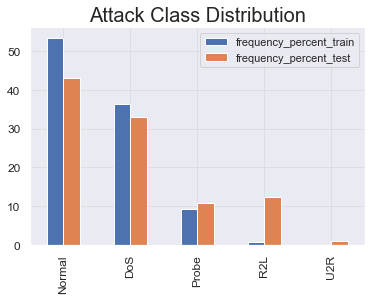

In [21]:
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [22]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.99), x.max()], 
                  index = ['COUNT', 'MISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                                'P99' ,'MAX'])

In [23]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), len(np.unique(x)), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/x.count()), 2)], 
                      index = ['COUNT', 'UNIQUE', 'MISS', 'MODE', 'FREQ', 'PERCENT'])

In [24]:
def dummy_var(df, col):
    dummies = pd.get_dummies(df[col], prefix = col, drop_first = True)
    df = pd.concat([df, dummies], axis = 1)
    df.drop(col, axis = 1, inplace = True )
    return df

In [25]:
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

#### Data Preparation 

In [26]:
cat_cols = set(['protocol_type', 'service', 'flag', 'attack_class', 'land', 'root_shell','is_host_login', 'is_guest_login', 'su_attempted',
               'activity','logged_in'])

cont_cols = ['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count',
       'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate',
       'dst_host_srv_serror_rate', 'duration', 'hot', 'logged_in',
       'num_access_files', 'num_compromised', 'num_failed_logins',
       'num_file_creations', 'num_root', 'num_shells', 'rerror_rate',
       'same_srv_rate', 'serror_rate', 'src_bytes', 'srv_count',
       'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate', 'urgent',
       'wrong_fragment']

In [27]:
train[cont_cols].apply(continuous_var_summary)

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,dst_host_srv_diff_host_rate,dst_host_srv_rerror_rate,dst_host_srv_serror_rate,duration,hot,logged_in,num_access_files,num_compromised,num_failed_logins,num_file_creations,num_root,num_shells,rerror_rate,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,urgent,wrong_fragment
COUNT,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05,125973.000000,125973.000000,125973.000000,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
MISS,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
SUM,1.059528e+07,7942.930000,2.491634e+09,2.294585e+07,10449.600000,14969.600000,18691.730000,65662.380000,35833.330000,1.456916e+07,4099.470000,15146.980000,35081.530000,3.617247e+07,25750.000000,49852.000000,516.000000,35178.000000,154.000000,1596.000000,38068.000000,52.000000,15111.530000,83259.040000,35837.370000,5.740179e+09,3.494225e+06,12259.900000,15265.820000,35585.530000,14.000000,2858.000000
MEAN,8.410755e+01,0.063053,1.977911e+04,1.821489e+02,0.082951,0.118832,0.148379,0.521242,0.284452,1.156530e+02,0.032542,0.120240,0.278485,2.871447e+02,0.204409,0.395736,0.004096,0.279250,0.001222,0.012669,0.302192,0.000413,0.119958,0.660928,0.284485,4.556674e+04,2.773789e+01,0.097322,0.121183,0.282485,0.000111,0.022687
MEDIAN,1.400000e+01,0.000000,0.000000e+00,2.550000e+02,0.020000,0.000000,0.000000,0.510000,0.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400000e+01,8.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
STD,1.145086e+02,0.180314,4.021269e+06,9.920621e+01,0.188922,0.306557,0.308997,0.448949,0.444784,1.107027e+02,0.112564,0.319459,0.445669,2.604515e+03,2.149968,0.489010,0.099370,23.942042,0.045239,0.483935,24.399618,0.022181,0.320436,0.439623,0.446456,5.870331e+06,7.263584e+01,0.259830,0.323647,0.447022,0.014366,0.253530
VAR,1.311222e+04,0.032513,1.617061e+13,9.841873e+03,0.035691,0.093977,0.095479,0.201556,0.197833,1.225510e+04,0.012671,0.102054,0.198621,6.783500e+06,4.622364,0.239131,0.009874,573.221387,0.002047,0.234193,595.341363,0.000492,0.102679,0.193268,0.199323,3.446079e+13,5.275965e+03,0.067512,0.104748,0.199829,0.000206,0.064277
MIN,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
P1,1.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
P99,5.110000e+02,1.000000,2.551900e+04,2.550000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,2.550000e+02,0.520000,1.000000,1.000000,9.590560e+03,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.454000e+04,4.920000e+02,1.000000,1.000000,1.000000,0.000000,0.000000


In [28]:
train[cat_cols].apply(categorical_var_summary)

,service,flag,root_shell,is_host_login,su_attempted,logged_in,attack_class,activity,land,protocol_type,is_guest_login
COUNT,125973,125973,125973.00,125973.0,125973.00,125973.00,125973,125973.00,125973.00,125973,125973.00
UNIQUE,70,11,2.00,2.0,3.00,2.00,5,2.00,2.00,3,2.00
MISS,0,0,0.00,0.0,0.00,0.00,0,0.00,0.00,0,0.00
MODE,http,SF,0.00,0.0,0.00,0.00,Normal,0.00,0.00,tcp,0.00
FREQ,40338,74945,125804.00,125972.0,125893.00,76121.00,67343,67343.00,125948.00,102689,124786.00
PERCENT,32.02,59.49,99.87,100.0,99.94,60.43,53.46,53.46,99.98,81.52,99.06


In [29]:
# Outlier Treatment
train[cont_cols] = train[cont_cols].apply(outlier_capping)
test[cont_cols] = test[cont_cols].apply(outlier_capping)

In [30]:
zero_cols = train.columns[(train==0).all()]
zero_cols

Index(['wrong_fragment', 'urgent', 'num_failed_logins', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files'],
      dtype='object')

In [31]:
# Dropping all the columns with 0 as they are redundant
train.drop(zero_cols, axis = 1, inplace = True)
test.drop(zero_cols, axis = 1, inplace = True)

In [32]:
# No of unique values are much greater
train.drop('service', axis = 1, inplace = True)
test.drop('service', axis = 1, inplace = True)

In [33]:
train.isna().sum()

duration                       0
protocol_type                  0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
hot                            0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_srv_count             0
dst_host_same_srv_rate         0
dst_host_diff_srv_rate         0
dst_host_same_src_port_rate    0
dst_host_srv_diff_host_rate    0
dst_host_serror_rate           0
dst_host_srv_serror_rate       0
dst_host_r

#### Encoding Categorical Variables 

In [34]:
for col in ('protocol_type', 'flag'):
    train = dummy_var(train, col)
    test  = dummy_var(test, col)

In [35]:
train.head()

,duration,src_bytes,dst_bytes,land,hot,logged_in,num_compromised,root_shell,su_attempted,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class,activity,protocol_type_tcp,protocol_type_udp,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0,0.0,0,0.0,0,0,0,0,2.0,2.0,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150.0,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0,0.0,0,0.0,0,0,0,0,13.0,1.0,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0,0,123.0,6.0,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255.0,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS,1,1,0,0,0,0,0,1,0,0,0,0,0
3,0.0,232.0,8153.0,0,0.0,1,0.0,0,0,0,0,5.0,5.0,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30.0,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0.0,199.0,420.0,0,0.0,1,0.0,0,0,0,0,30.0,32.0,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal,0,1,0,0,0,0,0,0,0,0,0,1,0


In [36]:
target_map = {'Normal':'0', 'DoS':'1', 'Probe':'2', 'R2L':'3', 'U2R':'4'}
train['attack_class'] = train['attack_class'].apply(lambda x: target_map[x])
test['attack_class'] = test['attack_class'].apply(lambda x: target_map[x])

train['attack_class'] = train['attack_class'].astype('int64')
test['attack_class'] = test['attack_class'].astype('int64')

In [37]:
train['attack_class'].value_counts()

0    67343
1    45927
2    11656
3      995
4       52
Name: attack_class, dtype: int64

In [38]:
cont_cols = ['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count',
       'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate',
       'dst_host_srv_serror_rate', 'duration', 'hot', 'logged_in', 'num_compromised','rerror_rate',
       'same_srv_rate', 'serror_rate', 'src_bytes', 'srv_count',
       'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate']

#### Standardizing Data 

In [39]:
scaler = StandardScaler()
train[cont_cols] = pd.DataFrame(scaler.fit_transform(train[cont_cols]), columns = cont_cols)
test[cont_cols] = pd.DataFrame(scaler.transform(test[cont_cols]), columns = cont_cols)

train[cont_cols].head()

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,dst_host_srv_diff_host_rate,dst_host_srv_rerror_rate,dst_host_srv_serror_rate,duration,hot,logged_in,num_compromised,rerror_rate,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate
0,-0.717047,-0.349683,-0.352792,-0.324063,-0.280282,-0.224532,0.069972,-0.782367,-0.639532,-0.818890,-0.320917,-0.376387,-0.624871,-0.138442,-0.140747,-0.809262,-0.101557,-0.374362,0.771283,-0.637209,-0.087734,-0.357788,-0.374560,-0.374432,-0.631929
1,-0.620984,0.482201,-0.352792,0.734343,2.736852,-0.387635,2.367737,-1.161030,-0.639532,-1.035688,-0.320917,-0.376387,-0.624871,-0.138442,-0.140747,-0.809262,-0.101557,-0.374362,-1.321428,-0.637209,-0.143942,-0.371789,-0.374560,-0.374432,-0.631929
2,0.339647,0.038529,-0.352792,0.734343,-0.174417,-0.387635,-0.480197,-0.938287,1.608759,-0.809857,-0.320917,-0.376387,1.618955,-0.138442,-0.140747,-0.809262,-0.101557,-0.374362,-1.389669,1.602664,-0.167729,-0.301781,-0.374560,-0.374432,1.605104
3,-0.690848,-0.349683,1.790321,-1.533670,-0.439078,-0.387635,-0.383108,1.066401,-0.572083,1.258754,0.112042,-0.345084,-0.602433,-0.138442,-0.140747,1.235694,-0.101557,-0.374362,0.771283,-0.189235,-0.129931,-0.315783,-0.374560,-0.374432,-0.184522
4,-0.472523,-0.349683,-0.242390,0.734343,-0.439078,-0.387635,-0.480197,1.066401,-0.639532,1.258754,-0.320917,-0.376387,-0.624871,-0.138442,-0.140747,1.235694,-0.101557,-0.374362,0.771283,-0.637209,-0.135307,0.062263,-0.028179,-0.374432,-0.631929


<AxesSubplot:>

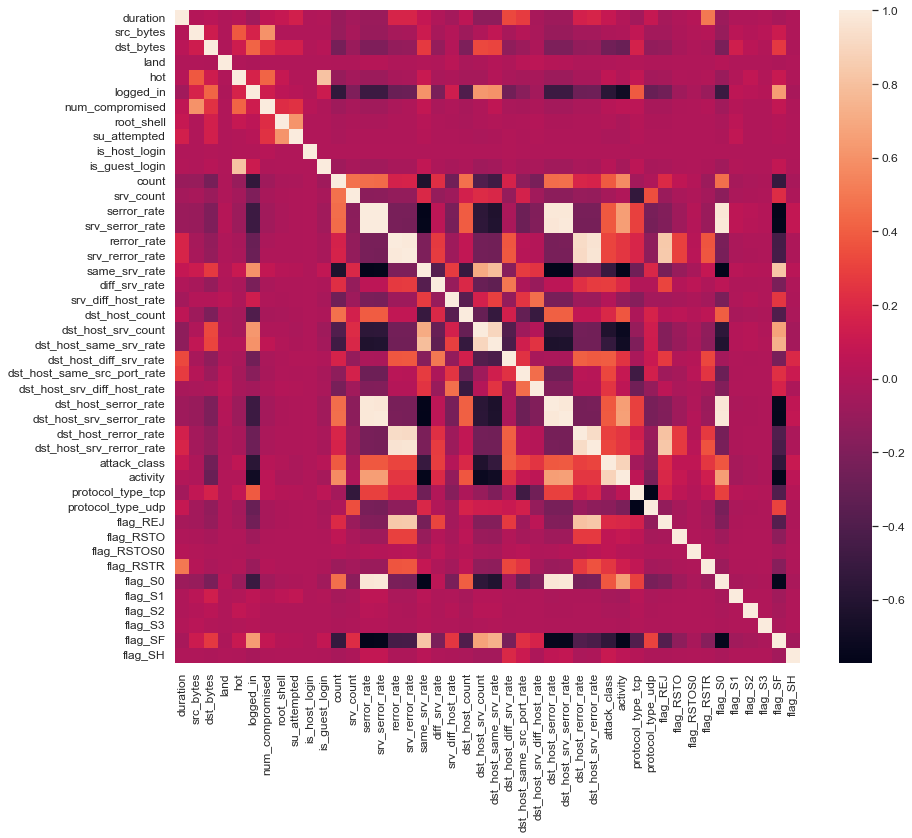

In [40]:
plt.figure(figsize = (14,12))
sns.heatmap(train.corr())

#### Feature Selection 

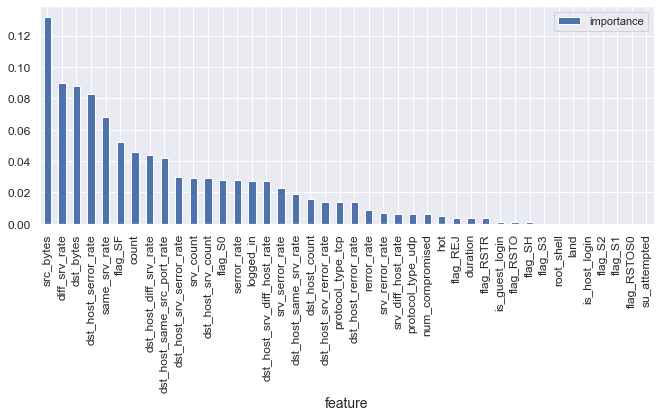

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier( random_state=101)

f_col = train.columns.difference(['activity','attack_class'])
# fit random forest classifier on the training set
rfc.fit(train[f_col], train['attack_class'])

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':f_col,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [42]:
rfc = RandomForestClassifier()
rfe = RFE(rfc,n_features_to_select=10)
rfe = rfe.fit(train[f_col], train['attack_class'])

In [43]:
new_col = f_col[rfe.support_]
new_col

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'flag_SF',
       'same_srv_rate', 'src_bytes', 'srv_count'],
      dtype='object')

In [45]:
X  = train[new_col]
Y = train['activity']

In [46]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.3, 
                                                    random_state = 123)

In [153]:
# Model - 1
#Getting parameters for best fit using GridSeachCV
param_grid = {'n_estimators' : [100,125,150],
              'max_depth' : [5,7,9]
              }

gs_rf = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 12), 
                     param_grid = param_grid,
                     scoring = 'roc_auc',
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)

In [154]:
gs_rf.best_params_

{'max_depth': 9, 'n_estimators': 150}

In [155]:
gs_rf.best_score_

0.9997623671099829

In [158]:
clf_rf = gs_rf.best_estimator_
clf_rf.fit(train_x, train_y)

#Making prediction on train and test data
rf_train_pred = clf_rf.predict(train_x)
rf_test_pred = clf_rf.predict(test_x)

#Calculating log loss
ll_rf = metrics.log_loss(test_y, clf_rf.predict_proba(test_x))

In [160]:
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, rf_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, rf_train_pred))
print("")
print("Test Dataset")
acc_rf = metrics.accuracy_score(test_y, rf_test_pred)
print("Accuracy : ", acc_rf)
print("AUC      : ", metrics.roc_auc_score(test_y, rf_test_pred))
print("Log Loss : ", ll_rf)

Model Performance
Train Dataset
Accuracy :  0.9950783048502512
AUC      :  0.9948686782763422

Test Dataset
Accuracy :  0.9940992802709568
AUC      :  0.9938678806038643
Log Loss :  0.023523995438881874


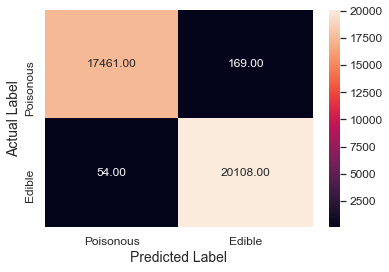

In [162]:
confusion_matrix = metrics.confusion_matrix(test_y, rf_test_pred, labels = [1,0])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', xticklabels = ['Poisonous', 'Edible'], yticklabels = ['Poisonous', 'Edible'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [163]:
#Getting classification metrics scores
print(metrics.classification_report(test_y, rf_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20162
           1       1.00      0.99      0.99     17630

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792



In [164]:
# Model2
pm = {
          'n_estimators' : [100],
          'learning_rate': [0.1]
     }

gscv_xg = GridSearchCV(estimator = XGBClassifier(random_state = 123), 
                    param_grid = pm,
                    cv = 10,
                    scoring = 'roc_auc',
                    n_jobs = -1).fit(train_x, train_y)

[12:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [165]:
xg = gscv_xg.best_estimator_
train_pred_xg = xg.predict(train_x)
test_pred_xg = xg.predict(test_x)

#Calculating log loss
log_xg = metrics.log_loss(test_y, xg.predict_proba(test_x))

In [166]:
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_xg))
print("AUC      : ", metrics.roc_auc_score(train_y, xg.predict_proba(train_x)[:,1]))
print("")
print("Test Dataset")
acc_score_xg = metrics.accuracy_score(test_y, test_pred_xg)
print("Accuracy : ", acc_score_xg)
auc_xg = metrics.roc_auc_score(test_y, xg.predict_proba(test_x)[:,1])
print("AUC      : ", auc_xg)
print("Log Loss : ", log_xg)

Model Performance
Train Dataset
Accuracy :  0.9976979167847949
AUC      :  0.9999692683237

Test Dataset
Accuracy :  0.9968247248094835
AUC      :  0.9998964569629225
Log Loss :  0.01121297896896055


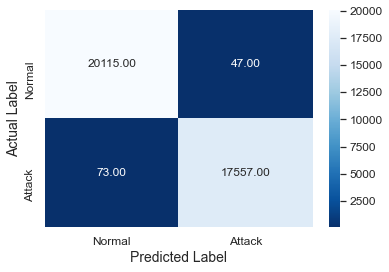

In [167]:
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_xg, labels = [0,1])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['Normal','Attack'],
            yticklabels = ['Normal','Attack'],
            cmap = 'Blues_r'    
           )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [168]:
print(metrics.classification_report(test_y, test_pred_xg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20162
           1       1.00      1.00      1.00     17630

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



In [170]:
# Model-3
train_x.shape

(88181, 10)

In [174]:
from keras.models import Sequential
from keras.layers import Dense

In [175]:
ann = Sequential()
#Adding input layer
ann.add(Dense(10, activation = 'relu', input_dim = 10))
#Adding hidden layer
ann.add(Dense(5, activation = 'relu'))
#Adding output layer
ann.add(Dense(1, activation = 'sigmoid'))

In [176]:
ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [178]:
#Compiling and fitting the model
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(train_x, train_y, epochs = 20, batch_size = 10, validation_data = (test_x, test_y))

Epoch 1/20
8819/8819 [==============================] - 8s 848us/step - loss: 0.1712 - accuracy: 0.9308 - val_loss: 0.0972 - val_accuracy: 0.9629
Epoch 2/20
8819/8819 [==============================] - 7s 779us/step - loss: 0.0927 - accuracy: 0.9649 - val_loss: 0.0866 - val_accuracy: 0.9667
Epoch 3/20
8819/8819 [==============================] - 7s 750us/step - loss: 0.0833 - accuracy: 0.9677 - val_loss: 0.0829 - val_accuracy: 0.9698
Epoch 4/20
8819/8819 [==============================] - 7s 756us/step - loss: 0.0788 - accuracy: 0.9706 - val_loss: 0.0793 - val_accuracy: 0.9710
Epoch 5/20
8819/8819 [==============================] - 7s 743us/step - loss: 0.0753 - accuracy: 0.9722 - val_loss: 0.0791 - val_accuracy: 0.9700
Epoch 6/20
8819/8819 [==============================] - 7s 750us/step - loss: 0.0760 - accuracy: 0.9726 - val_loss: 0.0753 - val_accuracy: 0.9728
Epoch 7/20
8819/8819 [==============================] - 7s 757us/step - loss: 0.0728 - accuracy: 0.9736 - val_loss: 0.0730 -

In [179]:
ann_train_pred = (ann.predict(train_x)>0.5).astype('int64')[:,0]
ann_test_pred = (ann.predict(test_x)>0.5).astype('int64')[:,0]

#Getting Log Loss
ll_ann = metrics.log_loss(test_y, ann_test_pred)

#Checking model performance
print("Model Performance")
print("Train Dataset")
print('Accuracy : ', metrics.accuracy_score(train_y, ann_train_pred))
print('AUC      : ', metrics.roc_auc_score(train_y, ann_train_pred))
print("")
print('Test Dataset -')
acc_ann = metrics.accuracy_score(test_y, ann_test_pred)
print('Accuracy : ', acc_ann)
print('AUC      : ', metrics.roc_auc_score(test_y, ann_test_pred))
print('Log Loss : ', ll_ann)

Model Performance
Train Dataset
Accuracy :  0.9771832934532382
AUC      :  0.9773837727154534

Test Dataset -
Accuracy :  0.9764500423370025
AUC      :  0.9767000174367543
Log Loss :  0.8133982528595999


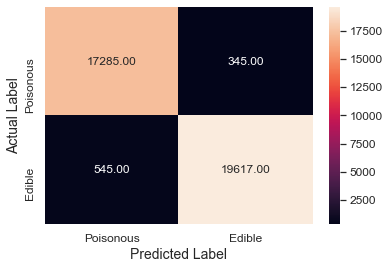

In [180]:
confusion_matrix = metrics.confusion_matrix(test_y, ann_test_pred, labels = [1,0])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', xticklabels = ['Poisonous', 'Edible'], yticklabels = ['Poisonous', 'Edible'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [182]:
print(metrics.classification_report(test_y, ann_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     20162
           1       0.97      0.98      0.97     17630

    accuracy                           0.98     37792
   macro avg       0.98      0.98      0.98     37792
weighted avg       0.98      0.98      0.98     37792

